In [137]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 100

import geopandas as gpd

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, offline
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt


from os import listdir
import unicodedata


from paths import *
from scripts.vis_graphs import remove_acentos
from scripts.vis_graphs import normalize_cols
from scripts.io import read_sheets
from scripts import io


from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')


import yaml

from IPython.display import IFrame


# Brasil.IO

In [109]:
from scripts import io

brio, brio_raw = io.load_brasilIO()

https://brasil.io/api/dataset/covid19/caso/data?format=json
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=2
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=3
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=4
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=5
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=6
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=7
https://brasil.io/api/dataset/covid19/caso/data?format=json&page=8


## WCota
 - [github](https://github.com/wcota/covid19br)

In [110]:
#data https://github.com/wcota/covid19br
dd = io.load_wcota()


## MYTABLE

In [142]:
from scripts.io import read_sheets
from scripts import manipulation

df = read_sheets('covid19_estados')

df_states = manipulation.manipule_mytable(df)

In [143]:
vale = read_sheets('covid19_vale_do_paraiba_e_litoral_norte').replace('',0)

### GRAPHS

[Local - Indicator Model](file:///mnt/0BF8481B1CDBF12D/Jlab/gabinete_sv/covid19/images/storage/br_indicator_model.html)

[Local - Indicator Final](file:///mnt/0BF8481B1CDBF12D/Jlab/gabinete_sv/covid19/images/storage/br_indicator_final.html)

[GS-Indicator_Final](https://storage.googleapis.com/sv-covid19/brasil/br_indicator_final.html)

In [144]:
from scripts import vis_html



vis_html.create_cards(df_states,vale)

name= "br_indicator_final.html"
path= f"../images/storage/{name}"

io.to_storage(bucket='sv-covid19',
          bucket_folder='brasil',
          file_name=name,
          path_to_file=path)

Done!


In [114]:
# IFrame(src=path, width=1500, height=600)

In [118]:
from scripts.vis_graphs import brasil_vis
from scripts import io

themes = yaml.load(open('../themes/custom_colorscales.yaml', 'r'), Loader=yaml.FullLoader)

df_states = df_states.sort_values(by=['date'],ascending=False)

escala  = 'lin'
save    = True
#### CHOSE CITIES TO START SELECTED IN GRAPH
in_cities = ['BRASIL','BRASIL SEM SP','SP', 'RJ']


## confirmed or deaths

for config in ['novo', 'novo_storage']:
    if config == 'novo':
        save = True
    else:
        save=False
    
    for var in ['deaths','confirmed']:
        fig = brasil_vis(df_states,
                         var,
                         in_cities,
                         today=today,
                         save=save,
                         themes=themes[config])

        if config == 'novo':
            pass
        else:
            name= "brasil_por_estado_{}.html".format(var)
            path= f"../images/storage/total/{name}"
            plot(fig, filename=path, auto_open=False)

            io.to_storage(bucket='sv-covid19',
                          bucket_folder='brasil',
                          file_name=name,
                          path_to_file=path)



Done!
Done!


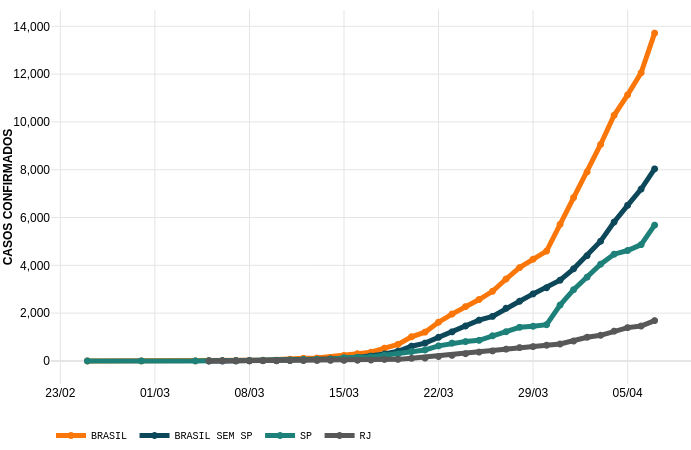

In [119]:
from scripts.vis_graphs import brasil_vis

themes = yaml.load(open('../themes/custom_colorscales.yaml', 'r'), Loader=yaml.FullLoader)

var = 'confirmed'
in_cities = ['BRASIL','BRASIL SEM SP','SP', 'RJ']

brasil_vis(df_states,
                 var,
                 in_cities,
                 today=today,
                 save=False,
                 themes=themes['novo_storage'])

In [140]:
from scripts import vis_graphs

brasil = df_states[df_states['state']=='BRASIL']
brasil['countrycode'] = 'Brasil'
brasil['countryname'] = 'Brasil'

for var in ['cases','deaths']:
    fig = vis_graphs.total_by_country(df = brasil, save=True,geoid='Brasil', var=var,themes = themes['novo_storage'])

    if var == 'cases':
        name= "brasil_lin_total.html"
    else:
        name = "brasil_lin_mortes.html"

    path= f"../images/storage/diario/{name}"
    plot(fig, filename=path, auto_open=False)

    io.to_storage(bucket='sv-covid19',
                  bucket_folder='brasil',
                  file_name=name,
                  path_to_file=path)

    

Done!
Done!


In [122]:
# fig.write_image("../images/brasil/brasil_por_estado_confirmed.pdf")




## MAPS

In [123]:
#minicipales data
municipios = pd.read_csv('../data/br_municipios_ibge.csv', dtype={'geocodigo':str})
df = brio.copy()

#load shape files;
ufs = gpd.read_file('../../mapas_brasil/estados-ibge/BRUFE250GC_SIR.shp')
maps = gpd.read_file('../../mapas_brasil/municipios-ibge/brasil-municipios.shp')

In [124]:
from scripts import manipulation
#prepare data for map
final, estados = manipulation.manipulate_for_br_maps(df, municipios, maps, df_states, ufs)

In [125]:
from scripts import vis_maps

#generate map
cols = ['Município','Estado','Confirmados', 'Óbitos', 'Data do Boletim']
mymap =  vis_maps.get_map(final,'Confirmados', cols, estados)

mymap.save('../maps/cidades_estados.html')
# mymap.save('../../sample_pages/images/covid19/maps/cidades_estados.html')

In [126]:
from scripts import io

io.to_storage(bucket='sv-covid19',
              bucket_folder='maps',
              file_name='cidades_estados.html',
              path_to_file='../maps/cidades_estados.html')

Done!


## Vale

In [127]:
from scripts.io import read_sheets
from scripts import manipulation
#download and manipulate vale data
df = read_sheets('covid19_vale_do_paraiba_e_litoral_norte')
df = manipulation.manipulate_vale_data(df)

#load shape files
municipios_sp = gpd.read_file('../../brasil_geodata/maps/sp_municipios.json')
ufs = gpd.read_file('../../mapas_brasil/estados-ibge/BRUFE250GC_SIR.shp')


In [128]:
## Manipulate data for generate map
vale, estados = manipulation.manipulate_for_vale_maps(df, municipios_sp, estados)

In [129]:
from scripts import vis_maps

cols = ['Município','Confirmados','Confirmados Internados','Óbitos','Óbitos Suspeitos','Suspeitos','Suspeitos Internados','Recuperados','Descartados','Data do Boletim']
mymap =  vis_maps.get_map_vale(vale,'Confirmados', cols, estados)
mymap.save('../maps/mapa_vale.html')


In [130]:
from scripts import io

io.to_storage(bucket='sv-covid19',
              bucket_folder='maps',
              file_name='mapa_vale.html',
              path_to_file='../maps/mapa_vale.html')

Done!


### TABLE

In [131]:
vale['Fonte'] = vale['Fonte'].apply(lambda x: f'<a href="{x}">LINK</a>')
# vale['suspeitas'] = vale['suspeitas'].astype(str).str.replace('.0','')


In [132]:
vale.head()

,Município,Suspeitos,Suspeitos Internados,Confirmados,Confirmados Internados,Descartados,Óbitos Suspeitos,Óbitos,Recuperados,Data do Boletim,ultima_atualizaçao,Fonte,nome_municipio,geometry,Estado
0,São José dos Campos,589,74,65,18,-,9,1,15,06/04/2020,06/04/2020,"<a href=""http://www.sjc.sp.gov.br/servicos/saude/coronavirus-acoes-em-sao-jose/informe-epidemiol...",São José dos Campos,"POLYGON ((-45.87098 -22.87149, -45.87096 -22.87185, -45.87096 -22.87213, -45.87097 -22.87226, -4...",São Paulo
1,Jacareí,73,-,4,-,13,1,1,-,06/04/2020,06/04/2020,"<a href=""https://www.instagram.com/prefeituradejacarei/"">LINK</a>",Jacareí,"POLYGON ((-45.79372 -23.29200, -45.79368 -23.29255, -45.79371 -23.29309, -45.79375 -23.29326, -4...",São Paulo
2,Taubaté,145,17,6,-,81,7,1,0,06/04/2020,06/04/2020,"<a href=""https://www.taubate.sp.gov.br/coronavirus/"">LINK</a>",Taubaté,"POLYGON ((-45.50363 -22.97899, -45.50354 -22.97935, -45.50303 -22.97983, -45.50273 -22.97982, -4...",São Paulo
3,São Sebastião,25,-,2,-,25,3,1,0,05/04/2020,06/04/2020,"<a href=""http://www.saosebastiao.sp.gov.br/noticia-lista.asp"">LINK</a>",São Sebastião,"MULTIPOLYGON (((-45.77929 -23.85776, -45.77855 -23.85835, -45.77677 -23.85835, -45.77595 -23.859...",São Paulo
4,Pindamonhangaba,95,6,1,-,16,3,1,0,05/04/2020,06/04/2020,"<a href=""http://www.pindamonhangaba.sp.gov.br/coronavirus/boletim.htm"">LINK</a>",Pindamonhangaba,"POLYGON ((-45.34690 -22.78786, -45.34713 -22.78937, -45.34778 -22.79002, -45.34818 -22.79016, -4...",São Paulo


In [133]:
cols = ['Município','Confirmados','Confirmados Internados','Óbitos','Óbitos Suspeitos','Suspeitos','Suspeitos Internados','Recuperados','Descartados','Data do Boletim', 'Fonte']
vale_table = vale[cols]

In [134]:
fig = go.Figure(data=[go.Table(
    header=dict(
        values=["<b>{}</b>".format(col).upper() for col in vale_table.columns],
        fill_color='#FF6D01',
        align='left',
        font=dict(color='white',size=10 ,family='Roboto'),
        line_color='darkslategray',

#         height=40
    )
    
    ,
    cells=dict(
        values=[vale_table[col].astype(str).apply(lambda x: f"<b>{x}</b>") for col in cols],
#         fill=dict(color=['#04738c','#04738c','#04738c','#04738c', 'white']),
#         fill_color = [['#04738c' if i>0 else 'white' for i in vale_table['Casos Confirmados'] ]*4],
        align='left',
        font=dict(color='#04738c',size=10 ,family='Roboto'),
        line_color='darkslategray',

        )
    )
])

fig = fig.update_layout(
    autosize=False,
    margin=dict(l=0, r=0, t=0, b=0),
    height = 1400,
    width = 1300,)


In [135]:
fig

In [136]:
plot(fig, filename="../images/storage/tabela/vale_table.html", auto_open=False)

from scripts import io

io.to_storage(bucket='sv-covid19',
              bucket_folder='maps',
              file_name='vale_table.html',
              path_to_file='../images/storage/tabela/vale_table.html')

Done!
